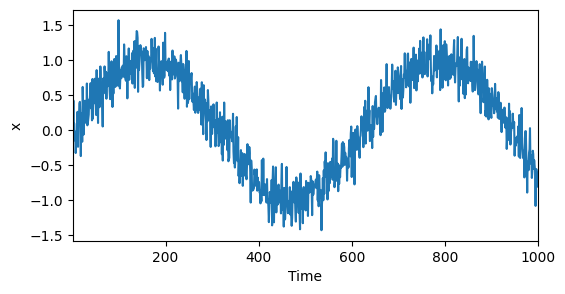

In [14]:
%matplotlib inline
import torch
from torch import nn
import matplotlib.pyplot as plt

T = 1000  # 总共产生1000个点
time_steps = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time_steps) + torch.normal(0, 0.2, (T,))

plt.plot(time_steps, x)  # 正确：传入 x 和 y
plt.xlabel("Time")       # 设置横坐标名称
plt.ylabel("x")          # 设置纵坐标名称
plt.xlim([1, 1000])      # 设置横轴范围
plt.gcf().set_size_inches(6, 3)  # 设置图像大小
plt.show()

In [4]:
%matplotlib inline
import math
import torch
from torch import nn
import os

from torch.nn import functional as F
from ml_model_utils import *

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [5]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [6]:
# 为了定义循环神经网络模型， 我们首先需要一个init_rnn_state函数在初始化时返回隐状态。 这个函数的返回是一个张量，张量全用0填充， 形状为（批量大小，隐藏单元数）。 在后面的章节中我们将会遇到隐状态包含多个变量的情况， 而使用元组可以更容易地处理些。
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [7]:
# 下面的rnn函数定义了如何在一个时间步内计算隐状态和输出。 循环神经网络模型通过inputs最外层的维度实现循环， 以便逐时间步更新小批量数据的隐状态H。 此外，这里使用tanh函数作为激活函数。 如 4.1节所述， 当元素在实数上满足均匀分布时，tanh函数的平均值为0。
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [8]:
# __init__: vocab_size: 词表大小，用于 one-hot 编码。
#     num_hiddens: 隐藏层的维度（隐藏状态的大小）。
#     device: 使用的设备（如 cpu() 或 cuda()）。
#     get_params: 一个函数，返回模型所需的参数（权重、偏置等）。
#     init_state: 一个函数，用于初始化 RNN 的隐藏状态。
#     forward_fn: 前向传播函数，定义 RNN 的核心计算逻辑。

# __call__
#     定义对象可以被当作函数调用：output, new_state = model(X, state)
#     X: 输入张量，形状为 (batch_size, num_steps)，表示一个 batch 的多个时间步。
#     state: 当前的隐藏状态。


class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        # X.T: 转置，将输入形状从 (batch_size, num_steps) 变为 (num_steps, batch_size)，因为我们按时间步处理。
        # F.one_hot(X.T, self.vocab_size): 对每个时间步和样本中的 token 进行 one-hot 编码，结果形状为 (num_steps, batch_size, vocab_size)。
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [9]:
X = torch.arange(20).reshape((4, 5))
F.one_hot(X.T, 28).shape

num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], try_gpu())
Y, new_state = net(X.to(try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([20, 28]), 1, torch.Size([4, 512]))